In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/"My Drive"

/content/drive/My Drive


In [0]:
%cd ./MyIntraShare/DIP-2019/FinalProject/

/content/drive/My Drive/MyIntraShare/DIP-2019/FinalProject


In [0]:
%ls

 300px-Unequalized_Hawkes_Bay_NZ.jpg   Project_List.pdf
 part1.png                            'Trial DE.ipynb'
'Priorities Project.gsheet'            underWaterCropped.jpg


In [0]:
# from google.colab import files
# files.upload()

In [0]:
%ls

'Priorities Project.gsheet'   Project_List.pdf  'Trial DE.ipynb'


In [0]:
from PIL import Image
import math
from scipy import ndimage
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
 
def image_entropy(img):
    """calculate the entropy of an image"""
    #import pdb;pdb.set_trace()
    img = Image.fromarray(img)
    histogram = img.histogram()
    histogram_length = sum(histogram)
 
    samples_probability = [float(h) / histogram_length for h in histogram]
 
    return -sum([p * math.log(p, 2) for p in samples_probability if p != 0])

def average_gradient(img):
  # # Get x-gradient in "sx"
  # sx = ndimage.sobel(img,axis=0,mode='constant')
  # # Get y-gradient in "sy"
  # sy = ndimage.sobel(img,axis=1,mode='constant')
  # # Get square root of sum of squares
  # sobel=np.hypot(sx,sy).astype('uint8')
  #avgGradient = sobel.sum()/(img.shape[0]*img.shape[1])

  dy,dx = np.gradient(img)
  avgGradient = np.sum(np.sqrt(dy**2+dx**2))/(img.shape[0]*img.shape[1])

  # # Hopefully see some edges
  # plt.imshow(sobel,cmap=plt.cm.gray)
  # plt.show()
  return avgGradient
 

def avgGradPlusEntropyForImg(img):
  entropy = image_entropy(img)
  avg_gradient = average_gradient(img)
  #print(entropy,avg_gradient)
  totalObjective = entropy + avg_gradient #BLACK AND WHITE
  return totalObjective


#img = cv2.imread('300px-Unequalized_Hawkes_Bay_NZ.jpg',0) #BLACK AND WHITE
#img = cv2.imread('./part1.png') #COLOR

#print(image_entropy(img),average_gradient(img))
#totalObjective = image_entropy(img)+average_gradient(img)#BLACK AND WHITE

# print(image_entropy(img[:,:,0]),average_gradient(img[:,:,0]),image_entropy(img[:,:,1]),average_gradient(img[:,:,1]),image_entropy(img[:,:,2]),average_gradient(img[:,:,2]))
# totalObjective = image_entropy(img[:,:,0])+average_gradient(img[:,:,0])+image_entropy(img[:,:,1])+average_gradient(img[:,:,1])+image_entropy(img[:,:,2])+average_gradient(img[:,:,2])

## Now use DE to get the three parameters of w, and apply one w each to R,G,B respectively and get their corresponding stretched image. Then pass that  

In [0]:
# from scipy.optimize import differential_evolution
# import numpy as np
# def ackley(x):
#   arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
#   arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
#   return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
# bounds = [(-5, 5), (-5, 5)]
# #result = differential_evolution(ackley, bounds)
# result = differential_evolution(ackley, bounds, popsize = 40, mutation=0.8, recombination=0.8, maxiter = 1000  )



In [0]:
from scipy.optimize import differential_evolution
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Load the color image
#img = cv2.imread('./part1.png') #COLOR
#img = cv2.imread('300px-Unequalized_Hawkes_Bay_NZ.jpg')
img = cv2.imread('./UnderwaterImageOneRock.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def stretchImageAndGetEntropyPlusGradient(w):
  #import pdb;pdb.set_trace()

  totalObjective = 0
  for i in range(3):
    #Figure lower_range and higher_range
    individualIntensities,countOfEachIntensity= np.unique(img[:,:,i],return_counts=True)
    probDensOfEachAvailableIntensity = countOfEachIntensity/countOfEachIntensity.sum()
    cumSum = np.cumsum(probDensOfEachAvailableIntensity)
    lower_limit =individualIntensities[np.where(cumSum <= w[i])[0][-1]]
    upper_limit = individualIntensities[np.where(cumSum >= (1-w[i]))[0][0]]
  
    #stretch image
    #imgContStretch = ((((img[:,:,i]/255)-w[i])*(1/(1-2*w[i])))*255).astype('uint8')
    tempImg = img[:,:,i]
    # plt.hist(img[:,:,i])
    # plt.show()
    imgContStretch = np.where((tempImg > lower_limit) & (tempImg < upper_limit),((( (tempImg)-lower_limit)*(255/(upper_limit - lower_limit)))).astype('uint8'),(tempImg).astype('uint8'))
    # plt.hist(imgContStretch)
    # plt.show()
    #Get total objective for this image
    totalObjective += avgGradPlusEntropyForImg(imgContStretch)
    # arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    # arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    # return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
    
  return totalObjective


In [0]:
#totObj

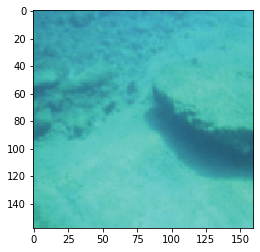

In [0]:
plt.imshow(img)

In [0]:
bounds = [(0,0.2), (0,0.2),(0,0.2)]
result = differential_evolution(stretchImageAndGetEntropyPlusGradient, bounds,disp=True, tol=1e-4,popsize = 40, mutation=0.8, recombination=0.8, maxiter = 1000  )


differential_evolution step 1: f(x)= 297.542
differential_evolution step 2: f(x)= 297.542
differential_evolution step 3: f(x)= 297.53
differential_evolution step 4: f(x)= 297.52
differential_evolution step 5: f(x)= 297.497
differential_evolution step 6: f(x)= 297.492
differential_evolution step 7: f(x)= 297.492
differential_evolution step 8: f(x)= 297.492
differential_evolution step 9: f(x)= 297.492
differential_evolution step 10: f(x)= 297.477
differential_evolution step 11: f(x)= 297.477
differential_evolution step 12: f(x)= 297.477
differential_evolution step 13: f(x)= 297.477
differential_evolution step 14: f(x)= 297.477
differential_evolution step 15: f(x)= 297.477
differential_evolution step 16: f(x)= 297.477
differential_evolution step 17: f(x)= 297.477
differential_evolution step 18: f(x)= 297.477
differential_evolution step 19: f(x)= 297.477


In [0]:
result

     fun: 297.4766110464405
 message: 'Optimization terminated successfully.'
    nfev: 2404
     nit: 19
 success: True
       x: array([0.06653022, 0.09401301, 0.13067969])

In [0]:
result['x']

array([0.16810989, 0.19284468, 0.19509115])

In [0]:
def reconstruct(result):
  #import pdb;pdb.set_trace()

  finalImage = np.zeros(img.shape)

  for idx,w in enumerate(result):
    individualIntensities,countOfEachIntensity= np.unique(img[:,:,idx],return_counts=True)
    probDensOfEachAvailableIntensity = countOfEachIntensity/countOfEachIntensity.sum()
    cumSum = np.cumsum(probDensOfEachAvailableIntensity)
    lower_limit =individualIntensities[np.where(cumSum <= w)[0][-1]]
    upper_limit = individualIntensities[np.where(cumSum >= (1-w))[0][0]]
    print(f'lower limit {lower_limit} upper limit {upper_limit} and w is {w}')

    tempImg = img[:,:,idx]
    output = np.where((tempImg > lower_limit) & (tempImg < upper_limit),((( tempImg-lower_limit)*(255/(upper_limit - lower_limit)))).astype('uint8'),(tempImg).astype('uint8'))
    finalImage[:,:,idx] = output

    #finalImage = np.concatenate( [imgContStretch,finalImage])
  return finalImage



In [0]:
outputImg = reconstruct(result['x'])

lower limit 44 upper limit 106 and w is 0.06653022324951455
lower limit 134 upper limit 202 and w is 0.09401300942521267
lower limit 156 upper limit 195 and w is 0.13067968534444838


In [0]:
outputImg.min(),outputImg.max()

(3.0, 251.0)

(<matplotlib.image.AxesImage at 0x7f5158d74898>, 3.0, 251.0)

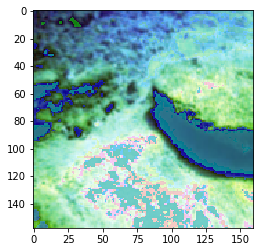

In [0]:
plt.imshow(outputImg.astype('uint8')),outputImg.min(),outputImg.max()